In [237]:
# import python libraries and spatial packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

# Task 1: Import, Clean, and Define Schema for Datasets

## Load datasets

In [238]:
# Import Businesses dataset
businesses_rawdf = pd.read_csv('Businesses.csv')
businesses = businesses_rawdf.copy() # prepare a working copy

# Import Stops dataset
stops_rawdf = pd.read_csv('Stops.txt', delimiter=',')
stops_df = stops_rawdf.copy() # prepare a working copy

# Import Polls dataset
polls_rawdf = pd.read_csv('PollingPlaces2019.csv')
polls_df = polls_rawdf.copy() # prepare a working copy


# Import Population dataset
population_rawdf = pd.read_csv('Population.csv')
population_df = population_rawdf.copy() # prepare a working copy

# Import Income dataset
income_rawdf = pd.read_csv('Income.csv')
income_df = income_rawdf.copy() # prepare a working copy

## Load Spatial Data (shapefiles)

### Geopandas Transformations

In [239]:
# Transform polls dataset
polls_df['geom'] = gpd.points_from_xy(polls_df.longitude, polls_df.latitude)  # creating the geometry column
polls_df = polls_df.drop(columns=['latitude', 'longitude', 'the_geom'])  # removing the old latitude/longitude fields

# Transform stops dataset
stops_df['geom'] = gpd.points_from_xy(stops_df.stop_lon, stops_df.stop_lat)  # creating the geometry column
stops_df = stops_df.drop(columns=['stop_lat', 'stop_lon'])  # removing the old latitude/longitude fields

# Load sa2_regions dataset
sa2_regions_path = 'SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp'
sa2_regions_rawgdf = gpd.read_file(sa2_regions_path)

# Load Schools dataset
future_gdf = gpd.read_file('catchments/catchments_future.shp')
primary_gdf = gpd.read_file('catchments/catchments_primary.shp')
secondary_gdf = gpd.read_file('catchments/catchments_secondary.shp')
schools_gdf = gpd.GeoDataFrame(pd.concat([future_gdf, primary_gdf, secondary_gdf], ignore_index=True)) # combining catchements into one dataset/table

## Database connection

In [240]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials copy.json"

# Helper functions provided in tutorial and recommended to be used in Ed

def pgconnect(credentials_filepath, db_schema="public"):
    with open(credentials_filepath) as f:
        db_conn_dict = json.load(f)
        host         = db_conn_dict['host']
        db_user      = db_conn_dict['user']
        db_pw        = db_conn_dict['password']
        default_db   = db_conn_dict['database']
        port         = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db, conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
        conn.commit()
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)

Connected successfully.


### SRID Transformations

In [241]:
# Perform SRID transformations

srid = 4326

def create_wkt_element(geom, srid):
    if geom is not None:
        if geom.geom_type == 'Polygon':
            geom = MultiPolygon([geom])
        return WKTElement(geom.wkt, srid)
    else:
        return None

# sa2_Regions Dataset
sa2_regions_gdf = sa2_regions_rawgdf.copy()  # creating a copy of the original for later
sa2_regions_gdf['geom'] = sa2_regions_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
sa2_regions_gdf = sa2_regions_gdf.drop(columns="geometry")  # deleting the old copy

# Stops dataset
stops_df['geom'] = stops_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid)) # srid transformation

# Polls dataset
polls_df['geom'] = polls_df['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid)) # srid transformation

# Schools dataset
schools_gdf['geom'] = schools_gdf['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=srid)) # srid transformation applying function
schools_gdf = schools_gdf.drop(columns="geometry")  # deleting the old copy

## Data Cleaning

In [242]:
# sa2_regions 
sa2_regions_gdf = sa2_regions_gdf[['SA2_CODE21', 'SA2_NAME21', 'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_NAME21', 'AREASQKM21', 'geom']] # filter desired columns
column_mapping = {col: col.lower() for col in sa2_regions_gdf.columns} # Map original column names to lowercase
sa2_regions_gdf = sa2_regions_gdf.rename(columns=column_mapping) # Rename columns with lowercase names
sa2_regions = sa2_regions_gdf.rename(columns={'sa2_code21' : 'sa2_code', 
                                              'sa2_name21' : 'sa2_name', 
                                              'sa3_code21' : 'sa3_code', 
                                              'sa3_name21' : 'sa3_name', 
                                              'sa4_code21' : 'sa4_code', 
                                              'sa4_name21' : 'sa4_name', 
                                              'gcc_name21' : 'gcc_name', 
                                              'areasqkm21' : 'area_sqkm'}) # implement normalized naming conventions
    
# businesses - no cleaning required

# stops
stops = stops_df[['stop_id', 'stop_name', 'parent_station', 'geom']] # select desired columns

# polls
polls = polls_df[['division_id', 'division_name', 'polling_place_id', 'polling_place_name', 'geom']] # filter desired columns


# schools
schools_gdf = schools_gdf[['USE_ID', 'CATCH_TYPE', 'USE_DESC', 'geom']] # filter desired columns
column_mapping = {col: col.lower() for col in schools_gdf.columns} # Map original column names to lowercase
schools_gdf = schools_gdf.rename(columns=column_mapping) # Rename columns with lowercase names
schools = schools_gdf.rename(columns={'use_id' : 'school_id', 
                                      'catch_type' : 'school_type', 
                                      'use_desc' : 'school_name'}) # implement normalized naming conventions
duplicate_schools = schools[schools.duplicated(['school_id', 'school_name'], keep='first')] # finding duplicate values
num_duplicates = len(duplicate_schools)
if num_duplicates > 0:
    print(f"Found {num_duplicates} duplicate rows in the schools table.")
    schools.drop_duplicates(['school_id', 'school_name'], keep='first', inplace=True) # dropping duplicate values
    print("Duplicates removed.")
    
# population
population = population_df[['sa2_code', 'sa2_name', '0-4_people', '5-9_people', '10-14_people', '15-19_people', 'total_people']] # filter desired columns (for scoring)

# income
income = income_df.rename(columns={'sa2_code21' : 'sa2_code'}) # normnalize naming conventions

Found 93 duplicate rows in the schools table.
Duplicates removed.


## Data Ingestion

### Define schemas

In [243]:
# Create SA2Regions table
conn.execute(text('''
DROP TABLE IF EXISTS sa2_regions CASCADE;
CREATE TABLE sa2_regions (
    sa2_code VARCHAR(9) PRIMARY KEY,
    sa2_name VARCHAR(255),
    sa3_code VARCHAR(5),
    sa3_name VARCHAR(255),
    sa4_code VARCHAR(3),
    sa4_name VARCHAR(255),
    gcc_name VARCHAR(255),
    area_sqkm NUMERIC,
    geom GEOMETRY(MULTIPOLYGON, 4326),
    CONSTRAINT unique_sa2_code UNIQUE (sa2_code),
    CONSTRAINT unique_sa2_name UNIQUE (sa2_name)
);'''
))

# Create Businesses table
conn.execute(text('''
    DROP TABLE IF EXISTS businesses;
    CREATE TABLE businesses (
    index SERIAL PRIMARY KEY,
    industry_code VARCHAR(1),
    industry_name VARCHAR(255),
    sa2_code VARCHAR(9) REFERENCES sa2_regions(sa2_code),
    sa2_name VARCHAR(255) REFERENCES sa2_regions(sa2_name),
    "0_to_50k_businesses" INTEGER,
    "50k_to_200k_businesses" INTEGER,
    "200k_to_2m_businesses" INTEGER,
    "2m_to_5m_businesses" INTEGER,
    "5m_to_10m_businesses" INTEGER,
    "10m_or_more_businesses" INTEGER,
    total_businesses INTEGER
);'''
))

# Create Stops table
conn.execute(text('''
DROP TABLE IF EXISTS stops;
CREATE TABLE stops (
    stop_id VARCHAR(8) PRIMARY KEY,
    stop_name VARCHAR(255),
    parent_station VARCHAR(8),
    geom GEOMETRY(POINT, 4326)
);'''
))

# Create Polls table
conn.execute(text('''
DROP TABLE IF EXISTS polls;
CREATE TABLE polls (
    division_id VARCHAR(3),
    division_name VARCHAR(255),
    polling_place_id VARCHAR(10) PRIMARY KEY,
    polling_place_name VARCHAR(255),
    geom GEOMETRY(POINT, 4326)
);'''
))

# Create Schools table
conn.execute(text('''
DROP TABLE IF EXISTS schools;
CREATE TABLE schools (
    school_id VARCHAR(5) PRIMARY KEY,
    school_type VARCHAR(25),
    school_name VARCHAR(255),
    geom GEOMETRY(MULTIPOLYGON, 4326)
);'''
))

# Create Population table
conn.execute(text('''
DROP TABLE IF EXISTS population;
CREATE TABLE population (
    sa2_code VARCHAR(9) REFERENCES sa2_regions(sa2_code),
    sa2_name VARCHAR(255) REFERENCES sa2_regions(sa2_name),
    "0-4_people" INTEGER, 
    "5-9_people" INTEGER, 
    "10-14_people" INTEGER, 
    "15-19_people" INTEGER, 
    total_people INTEGER,
    PRIMARY KEY (sa2_code)
);'''
))

# Create Income table
conn.execute(text('''
DROP TABLE IF EXISTS income;
CREATE TABLE income (
    sa2_code VARCHAR(9) REFERENCES sa2_regions(sa2_code),
    sa2_name VARCHAR(255) REFERENCES sa2_regions(sa2_name),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER,
    PRIMARY KEY (sa2_code)
);'''
))

### Populate newly created tables in our database with cleaned data

In [244]:
# Populate newly created tables in our database with cleaned data
try:
    # sa2_regions table
    sa2_regions.to_sql('sa2_regions', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
    print("sa2_regions table populated successfully.")
    print(query(conn, "select * from sa2_regions"))
except Exception as e:
    print("Error populating sa2_regions table:", e)

try:
    # businesses table
    businesses.to_sql('businesses', con=conn, if_exists='replace', index=False)
    print("businesses table populated successfully.")
    print(query(conn, "select * from businesses"))
except Exception as e:
    print("Error populating businesses table:", e)

try:
    # stops table
    stops.to_sql('stops', con=conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
    print("stops table populated successfully.")
    print(query(conn, "select * from stops"))
except Exception as e:
    print("Error populating stops table:", e)

try:
    # polls table
    polls.to_sql('polls', con=conn, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
    print("polls table populated successfully.")
    print(query(conn, "select * from polls"))
except Exception as e:
    print("Error populating polls table:", e)

try:
    # schools table
    schools.to_sql('schools', con=conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
    print("schools table populated successfully.")
    print(query(conn, "select * from schools"))
except Exception as e:
    print("Error populating schools table:", e)

try:
    # population table
    population.to_sql('population', con=conn, if_exists='replace', index=False)
    print("population table populated successfully.")
    print(query(conn, "select * from population"))
except Exception as e:
    print("Error populating population table:", e)

try:
    # income table
    income.to_sql('income', con=conn, if_exists='replace', index=False)
    print("income table populated successfully.")
    print(query(conn, "select * from income"))
except Exception as e:
    print("Error populating income table:", e)

sa2_regions table populated successfully.
       sa2_code                              sa2_name sa3_code  \
0     101021007                             Braidwood    10102   
1     101021008                               Karabar    10102   
2     101021610                               Googong    10102   
3     101021611                  Queanbeyan Surrounds    10102   
4     101031013                               Bombala    10103   
...         ...                                   ...      ...   
2468  901031003                            Jervis Bay    90103   
2469  901041004                        Norfolk Island    90104   
2470  997979799  Migratory - Offshore - Shipping (OT)    99797   
2471  999999499                 No usual address (OT)    99999   
2472  ZZZZZZZZZ                     Outside Australia    ZZZZZ   

                                  sa3_name sa4_code  \
0                               Queanbeyan      101   
1                               Queanbeyan      101   


# Task 2: Compute "Well Resourced" Score (First Section)

## Calculate Z-Scores

In [245]:
query = '''
CREATE TABLE IF NOT EXISTS z_businesses (
    sa2_code VARCHAR(9) PRIMARY KEY,
    region_score NUMERIC,
    z_score NUMERIC
);

WITH region_scores AS (
    SELECT 
        sa.sa2_code::text AS sa2_code,
        (SUM(b.total_businesses)::float / pop.total_people * 1000) AS region_score
    FROM 
        sa2_regions sa
    LEFT JOIN 
        businesses b ON sa.sa2_code::bigint = b.sa2_code::bigint
    LEFT JOIN 
        population pop ON sa.sa2_code::text = pop.sa2_code::text
    WHERE 
        pop.total_people >= 100
    GROUP BY 
        sa.sa2_code, pop.total_people
)

INSERT INTO z_businesses (sa2_code, region_score)
SELECT 
    sa2_code,
    region_score
FROM 
    region_scores;

WITH stats AS (
    SELECT 
        AVG(region_score) AS mean_region_score,
        STDDEV(region_score) AS stddev_region_score
    FROM 
        z_businesses
)

UPDATE z_businesses
SET z_score = (region_score - mean_region_score) / stddev_region_score
FROM stats;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("z_businesses created")

z_businesses created


In [246]:
query = '''
CREATE TABLE IF NOT EXISTS z_stops (
    sa2_code VARCHAR(9) PRIMARY KEY,
    region_score NUMERIC,
    z_score NUMERIC
);

WITH z_scores AS (
    SELECT 
        sa.sa2_code::text AS sa2_code,
        (COUNT(s.stop_id)::float / pop.total_people * 1000) AS region_score
    FROM 
        sa2_regions sa
    LEFT JOIN 
        stops s ON ST_Contains(sa.geom, s.geom)
    LEFT JOIN 
        population pop ON sa.sa2_code::text = pop.sa2_code::text
    WHERE 
        pop.total_people >= 100
    GROUP BY 
        sa.sa2_code, pop.total_people
)

INSERT INTO z_stops (sa2_code, region_score)
SELECT 
    sa2_code,
    region_score
FROM 
    z_scores;

UPDATE z_stops SET z_score = (region_score - avg_score) / stddev_score
FROM (
    SELECT 
        AVG(region_score) AS avg_score,
        STDDEV(region_score) AS stddev_score
    FROM 
        z_stops
) AS stats;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("z_stops created")

z_stops created


In [247]:
query = '''
CREATE TABLE IF NOT EXISTS z_polls (
    sa2_code VARCHAR(9) PRIMARY KEY,
    region_score NUMERIC,
    z_score NUMERIC
);

WITH z_scores AS (
    SELECT 
        sa.sa2_code::text AS sa2_code,
        (COUNT(p.polling_place_id)::float / pop.total_people * 1000) AS region_score
    FROM 
        sa2_regions sa
    LEFT JOIN 
        polls p ON ST_Contains(sa.geom, p.geom)
    LEFT JOIN 
        population pop ON sa.sa2_code::text = pop.sa2_code::text
    WHERE 
        pop.total_people >= 100
    GROUP BY 
        sa.sa2_code, pop.total_people
)

INSERT INTO z_polls (sa2_code, region_score)
SELECT 
    sa2_code,
    region_score
FROM 
    z_scores;

UPDATE z_polls SET z_score = (region_score - avg_score) / stddev_score
FROM (
    SELECT 
        AVG(region_score) AS avg_score,
        STDDEV(region_score) AS stddev_score
    FROM 
        z_polls
) AS stats;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("z_polls created")

z_polls created


In [248]:
query = '''
CREATE TABLE IF NOT EXISTS z_schools (
    sa2_code VARCHAR(9) PRIMARY KEY,
    region_score NUMERIC,
    z_score NUMERIC
);

WITH z_scores AS (
    SELECT 
        sa.sa2_code::text AS sa2_code,
        (COUNT(sc.school_id)::float / (pop."0-4_people" + pop."5-9_people" + pop."10-14_people" + pop."15-19_people") * 1000) AS region_score
    FROM 
        sa2_regions sa
    LEFT JOIN 
        schools sc ON ST_Intersects(sa.geom, sc.geom)
    LEFT JOIN 
        population pop ON sa.sa2_code::text = pop.sa2_code::text
    WHERE 
        pop.total_people >= 100
    GROUP BY 
        sa.sa2_code, pop."0-4_people", pop."5-9_people", pop."10-14_people", pop."15-19_people"
)

INSERT INTO z_schools (sa2_code, region_score)
SELECT 
    sa2_code,
    region_score
FROM 
    z_scores;

UPDATE z_schools SET z_score = (region_score - avg_score) / stddev_score
FROM (
    SELECT 
        AVG(region_score) AS avg_score,
        STDDEV(region_score) AS stddev_score
    FROM 
        z_schools
) AS stats;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("z_schools created")

z_schools created


# Task 3: Employing Extra Datasets

## Import Datasets

In [249]:
conn.rollback()

conn.execute(text('''
DROP TABLE IF EXISTS homelessness;
CREATE TABLE homelessness (
    sa2_name_2016 VARCHAR(255) REFERENCES sa2_regions(sa2_name),
    hl_p_homeless_tot INTEGER,
    sa2_main16 VARCHAR(9) REFERENCES sa2_regions(sa2_code),
    PRIMARY KEY (sa2_main16)
);'''
))

homelessness_file = 'Homelessness NSW.json'
gdf = gpd.read_file(homelessness_file)
attributes_to_keep = ['sa2_name_2016', 'hl_p_homeless_tot', 'sa2_main16', 'geometry']
gdf = gdf[attributes_to_keep]
gdf['geometry'] = gdf['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))
table_name = 'homelessness'
gdf.to_sql(table_name, con=conn, if_exists='replace', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid=4326)})

conn.commit()

print("homeless table created")

/var/folders/tt/pc3jtqhx7c549bg41942p1dm0000gn/T/ipykernel_23907/1359905746.py:17: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))


homeless table created


In [250]:
conn.rollback()

conn.execute(text('''
DROP TABLE IF EXISTS energy;
CREATE TABLE energy (
    sa2_name_2011 VARCHAR(255) REFERENCES sa2_regions(sa2_name),
    sa2_code_2011 VARCHAR(9) REFERENCES sa2_regions(sa2_code),
    year INTEGER,
    land_area_ha INTEGER,
    wu_ag_area_ha INTEGER,
    wu_irrigated_area_ha INTEGER,
    wu_vol_wat_app_ml INTEGER,
    wu_wat_oth_ag_use_ml INTEGER,
    wu_tot_wat_user_ml INTEGER,
    wu_app_rate_ml_per_ha INTEGER,
    esg_gen_meters INTEGER,
    esg_non_gen_meters INTEGER,
    esg_tot_meters INTEGER,
    esg_meter_dwell_gen_elec_pc INTEGER,
    mksfg_net_meters_kwh INTEGER,
    mksfg_gross_meters_kwh INTEGER,
    mksfg_non_gen_meters_kwh INTEGER,
    solar_panel_system INTEGER,
    solar_water_heater INTEGER,
    PRIMARY KEY (sa2_name_2011)
);'''
))

energy_file = 'Energy NSW.json'
gdf = gpd.read_file(energy_file)
attributes_to_keep = [
    'sa2_name_2011',
    'sa2_code_2011',
    'year',
    'land_area_ha',
    'wu_ag_area_ha',
    'wu_irrigated_area_ha',
    'wu_vol_wat_app_ml',
    'wu_wat_oth_ag_use_ml',
    'wu_tot_wat_use_ml',
    'wu_app_rate_ml_per_ha',
    'esg_gen_meters',
    'esg_non_gen_meters',
    'esg_tot_meters',
    'esg_meter_dwell_gen_elec_pc',
    'mksfg_net_meters_kwh',
    'mksfg_gross_meters_kwh',
    'mksfg_non_gen_meters_kwh',
    'solar_panel_system',
    'solar_water_heater',
    'geometry'
]
gdf = gdf[attributes_to_keep]
gdf['geometry'] = gdf['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))
table_name = 'energy'
gdf.to_sql(table_name, con=conn, if_exists='replace', index=False, dtype={'geometry': Geometry('MULTIPOLYGON', srid=4326)})

conn.commit()

print("energy table created")

/var/folders/tt/pc3jtqhx7c549bg41942p1dm0000gn/T/ipykernel_23907/1578048262.py:54: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326))


energy table created


## Calculate Z-Scores

In [251]:
query = '''
CREATE TABLE IF NOT EXISTS z_homelessness (
    sa2_code VARCHAR(9) PRIMARY KEY,
    z_score NUMERIC
);

WITH homeless_z_scores AS (
    SELECT
        sa2_main16 AS sa2_code,
        (hl_p_homeless_tot - AVG(hl_p_homeless_tot) OVER()) / NULLIF(STDDEV(hl_p_homeless_tot) OVER(), 0) AS z_score
    FROM homelessness
)

INSERT INTO z_homelessness (sa2_code, z_score)
SELECT sa2_code, z_score
FROM homeless_z_scores;

CREATE TABLE IF NOT EXISTS z_energy (
    sa2_code VARCHAR(9) PRIMARY KEY,
    z_score NUMERIC
);

WITH energy_z_scores AS (
    SELECT
        sa2_code_2011 AS sa2_code,
        (esg_tot_meters - AVG(esg_tot_meters) OVER()) / NULLIF(STDDEV(esg_tot_meters) OVER(), 0) AS z_score
    FROM energy
    WHERE year = '2011'
)

INSERT INTO z_energy (sa2_code, z_score)
SELECT sa2_code, z_score
FROM energy_z_scores;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("z_homelessness z_energy created")

z_homelessness z_energy created


# Task 3: Compute "Well Resourced" Score (Second Section)

## Calculate Sigmoid Score

In [252]:
query = '''
CREATE TABLE IF NOT EXISTS well_resourced_score (
    sa2_code VARCHAR(9) PRIMARY KEY,
    score NUMERIC
);

INSERT INTO well_resourced_score (sa2_code, score)
SELECT
    z_businesses.sa2_code,
    1 / (1 + EXP(- (
        z_businesses.z_score + 
        z_stops.z_score + 
        z_polls.z_score + 
        z_schools.z_score + 
        COALESCE(z_energy.z_score, 0) - 
        COALESCE(z_homelessness.z_score, 0)
    ))) AS well_resourced_score
FROM
    z_businesses
JOIN
    z_stops ON z_businesses.sa2_code = z_stops.sa2_code
JOIN
    z_polls ON z_businesses.sa2_code = z_polls.sa2_code
JOIN
    z_schools ON z_businesses.sa2_code = z_schools.sa2_code
LEFT JOIN
    z_energy ON z_businesses.sa2_code = z_energy.sa2_code
LEFT JOIN
    z_homelessness ON z_businesses.sa2_code = z_homelessness.sa2_code;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("wrs created")

wrs created


# Task 3 Data analysis

## Database alterations for visualization

In [253]:
query = '''
    ALTER TABLE well_resourced_score
    ADD COLUMN geom geometry;
    
    UPDATE well_resourced_score
    SET geom = sa2_regions.geom
    FROM sa2_regions
    WHERE well_resourced_score.sa2_code = sa2_regions.sa2_code;

    ALTER TABLE well_resourced_score
    ADD COLUMN gcc_name VARCHAR(100);
    
    UPDATE well_resourced_score
    SET gcc_name = s.gcc_name
    FROM sa2_regions s
    WHERE well_resourced_score.sa2_code = s.sa2_code;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("geom column added")

geom column added


In [254]:
query = '''
    ALTER TABLE z_businesses
    ADD COLUMN geom geometry(MultiPolygon, 4326);
    
    UPDATE z_businesses z
    SET geom = s.geom
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;

    ALTER TABLE z_businesses
    ADD COLUMN gcc_name VARCHAR(100);
    
    UPDATE z_businesses z
    SET gcc_name = s.gcc_name
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("geom column added")

geom column added


In [255]:
query = '''
    ALTER TABLE z_energy
    ADD COLUMN geom geometry(MultiPolygon, 4326);
    
    UPDATE z_energy z
    SET geom = s.geom
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;

    ALTER TABLE z_energy
    ADD COLUMN gcc_name VARCHAR(100);
    
    UPDATE z_energy z
    SET gcc_name = s.gcc_name
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("geom column added")

geom column added


In [256]:
query = '''
    ALTER TABLE z_homelessness
    ADD COLUMN geom geometry(MultiPolygon, 4326);
    
    UPDATE z_homelessness z
    SET geom = s.geom
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;

    ALTER TABLE z_homelessness
    ADD COLUMN gcc_name VARCHAR(100);
    
    UPDATE z_homelessness z
    SET gcc_name = s.gcc_name
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("geom column added")

geom column added


In [257]:
query = '''
    ALTER TABLE z_polls
    ADD COLUMN geom geometry(MultiPolygon, 4326);
    
    UPDATE z_polls z
    SET geom = s.geom
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;

    ALTER TABLE z_polls
    ADD COLUMN gcc_name VARCHAR(100);
    
    UPDATE z_polls z
    SET gcc_name = s.gcc_name
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("geom column added")

geom column added


In [258]:
query = '''
    ALTER TABLE z_schools
    ADD COLUMN geom geometry(MultiPolygon, 4326);
    
    UPDATE z_schools z
    SET geom = s.geom
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;

    ALTER TABLE z_schools
    ADD COLUMN gcc_name VARCHAR(100);
    
    UPDATE z_schools z
    SET gcc_name = s.gcc_name
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("geom column added")

geom column added


In [259]:
query = '''
    ALTER TABLE z_stops
    ADD COLUMN geom geometry(MultiPolygon, 4326);
    
    UPDATE z_stops z
    SET geom = s.geom
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;

    ALTER TABLE z_stops
    ADD COLUMN gcc_name VARCHAR(100);
    
    UPDATE z_stops z
    SET gcc_name = s.gcc_name
    FROM sa2_regions s
    WHERE z.sa2_code = s.sa2_code;
'''

# Execute the query
conn.execute(text(query))

# Commit the changes
conn.commit()

print("geom column added")

geom column added


## Interactive Map Visualization

## Connect to the database

In [294]:
import folium
from shapely.geometry import shape
import json

# Load credentials from JSON file
with open("Credentials copy.json", "r") as file:
    credentials = json.load(file)

# Extract database connection information
database = credentials["database"]
user = credentials["user"]
password = credentials["password"]
host = credentials["host"]
port = credentials["port"]

# Connect to the database
conn = psycopg2.connect(
    database=database,
    user=user,
    password=password,
    host=host,
    port=port
)

cur = conn.cursor()

## Interactive Maps

In [276]:
# Query scores and geometry data
cur.execute("""
    SELECT score, ST_AsGeoJSON(geom)
    FROM well_resourced_score
""")
rows = cur.fetchall()

# Convert geometry data to GeoJSON format
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for row in rows:
    score = float(row[0])
    geometry_str = row[1]  # Get the string representation of geometry
    
    # Parse the string representation of geometry into a Python dictionary
    geometry = json.loads(geometry_str)
    
    # Convert the geometry to a Shapely object
    geometry = shape(geometry)
    
    # Convert the geometry to a simple Polygon if it's a MultiPolygon
    if geometry.geom_type == 'MultiPolygon':
        geometry = geometry.convex_hull
    
    feature = {
        "type": "Feature",
        "id": len(geojson["features"]),  # Assign a unique ID to each feature
        "properties": {
            "score": score
        },
        "geometry": geometry.__geo_interface__
    }
    geojson["features"].append(feature)

# Create a Folium map
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10)

# Define the number of bins
num_bins = 50

# Convert the list of dictionaries into a dictionary
data_dict = {index: feature['properties']['score'] for index, feature in enumerate(geojson['features'])}

# Create a Choropleth layer using the GeoJSON data
choropleth = folium.Choropleth(
    geo_data=geojson,
    name='Choropleth',
    data=data_dict,  # Pass the dictionary of features
    key_on='feature.id',  # Key on the feature identifier
    fill_color='YlGn',  # Default color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Score',
    highlight=True,
    bins=num_bins  # Specify the number of bins
).add_to(m)

# Add tooltip to show score on click
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(fields=['score'], aliases=['Score']))

# Display the map
m


In [262]:
# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [279]:
# Query scores and geometry data
cur.execute("""
    SELECT z_score, ST_AsGeoJSON(geom)
    FROM z_businesses
""")
rows = cur.fetchall()

# Convert geometry data to GeoJSON format
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for row in rows:
    score = float(row[0])
    geometry_str = row[1]  # Get the string representation of geometry
    
    # Parse the string representation of geometry into a Python dictionary
    geometry = json.loads(geometry_str)
    
    # Convert the geometry to a Shapely object
    geometry = shape(geometry)
    
    # Convert the geometry to a simple Polygon if it's a MultiPolygon
    if geometry.geom_type == 'MultiPolygon':
        geometry = geometry.convex_hull
    
    # Apply sigmoid function to the z-score
    score = sigmoid(score)
    
    feature = {
        "type": "Feature",
        "id": len(geojson["features"]),  # Assign a unique ID to each feature
        "properties": {
            "score": score
        },
        "geometry": geometry.__geo_interface__
    }
    geojson["features"].append(feature)

# Create a Folium map
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10)

# Define the number of bins
num_bins = 5

# Convert the list of dictionaries into a dictionary
data_dict = {index: feature['properties']['score'] for index, feature in enumerate(geojson['features'])}

# Create a Choropleth layer using the GeoJSON data
choropleth = folium.Choropleth(
    geo_data=geojson,
    name='Choropleth',
    data=data_dict,  # Pass the dictionary of features
    key_on='feature.id',  # Key on the feature identifier
    fill_color='RdYlGn',  # Default color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Score',
    highlight=True,
    bins=num_bins  # Specify the number of bins
).add_to(m)

# Add tooltip to show score on click
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(fields=['score'], aliases=['Score']))

# Display the map
m


In [280]:
# Query scores and geometry data
cur.execute("""
    SELECT z_score, ST_AsGeoJSON(geom)
    FROM z_polls
""")
rows = cur.fetchall()

# Convert geometry data to GeoJSON format
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for row in rows:
    score = float(row[0])
    geometry_str = row[1]  # Get the string representation of geometry
    
    # Parse the string representation of geometry into a Python dictionary
    geometry = json.loads(geometry_str)
    
    # Convert the geometry to a Shapely object
    geometry = shape(geometry)
    
    # Convert the geometry to a simple Polygon if it's a MultiPolygon
    if geometry.geom_type == 'MultiPolygon':
        geometry = geometry.convex_hull

    score = sigmoid(score)
    
    feature = {
        "type": "Feature",
        "id": len(geojson["features"]),  # Assign a unique ID to each feature
        "properties": {
            "score": score
        },
        "geometry": geometry.__geo_interface__
    }
    geojson["features"].append(feature)

# Create a Folium map
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10)

# Define the number of bins
num_bins = 50

# Convert the list of dictionaries into a dictionary
data_dict = {index: feature['properties']['score'] for index, feature in enumerate(geojson['features'])}

# Create a Choropleth layer using the GeoJSON data
choropleth = folium.Choropleth(
    geo_data=geojson,
    name='Choropleth',
    data=data_dict,  # Pass the dictionary of features
    key_on='feature.id',  # Key on the feature identifier
    fill_color='RdYlGn',  # Default color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Score',
    highlight=True,
    bins=num_bins  # Specify the number of bins
).add_to(m)

# Add tooltip to show score on click
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(fields=['score'], aliases=['Score']))

# Display the map
m

In [281]:
# Query scores and geometry data
cur.execute("""
    SELECT z_score, ST_AsGeoJSON(geom)
    FROM z_schools
""")
rows = cur.fetchall()

# Convert geometry data to GeoJSON format
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for row in rows:
    score = float(row[0])
    geometry_str = row[1]  # Get the string representation of geometry
    
    # Parse the string representation of geometry into a Python dictionary
    geometry = json.loads(geometry_str)
    
    # Convert the geometry to a Shapely object
    geometry = shape(geometry)
    
    # Convert the geometry to a simple Polygon if it's a MultiPolygon
    if geometry.geom_type == 'MultiPolygon':
        geometry = geometry.convex_hull

    score = sigmoid(score)
    
    feature = {
        "type": "Feature",
        "id": len(geojson["features"]),  # Assign a unique ID to each feature
        "properties": {
            "score": score
        },
        "geometry": geometry.__geo_interface__
    }
    geojson["features"].append(feature)

# Create a Folium map
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10)

# Define the number of bins
num_bins = 50

# Convert the list of dictionaries into a dictionary
data_dict = {index: feature['properties']['score'] for index, feature in enumerate(geojson['features'])}

# Create a Choropleth layer using the GeoJSON data
choropleth = folium.Choropleth(
    geo_data=geojson,
    name='Choropleth',
    data=data_dict,  # Pass the dictionary of features
    key_on='feature.id',  # Key on the feature identifier
    fill_color='RdYlGn',  # Default color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Score',
    highlight=True,
    bins=num_bins  # Specify the number of bins
).add_to(m)

# Add tooltip to show score on click
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(fields=['score'], aliases=['Score']))

# Display the map
m

In [282]:
# Query scores and geometry data
cur.execute("""
    SELECT z_score, ST_AsGeoJSON(geom)
    FROM z_stops
""")
rows = cur.fetchall()

# Convert geometry data to GeoJSON format
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for row in rows:
    score = float(row[0])
    geometry_str = row[1]  # Get the string representation of geometry
    
    # Parse the string representation of geometry into a Python dictionary
    geometry = json.loads(geometry_str)
    
    # Convert the geometry to a Shapely object
    geometry = shape(geometry)
    
    # Convert the geometry to a simple Polygon if it's a MultiPolygon
    if geometry.geom_type == 'MultiPolygon':
        geometry = geometry.convex_hull

    score = sigmoid(score)
    
    feature = {
        "type": "Feature",
        "id": len(geojson["features"]),  # Assign a unique ID to each feature
        "properties": {
            "score": score
        },
        "geometry": geometry.__geo_interface__
    }
    geojson["features"].append(feature)

# Create a Folium map
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10)

# Define the number of bins
num_bins = 50

# Convert the list of dictionaries into a dictionary
data_dict = {index: feature['properties']['score'] for index, feature in enumerate(geojson['features'])}

# Create a Choropleth layer using the GeoJSON data
choropleth = folium.Choropleth(
    geo_data=geojson,
    name='Choropleth',
    data=data_dict,  # Pass the dictionary of features
    key_on='feature.id',  # Key on the feature identifier
    fill_color='RdYlGn',  # Default color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Score',
    highlight=True,
    bins=num_bins  # Specify the number of bins
).add_to(m)

# Add tooltip to show score on click
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(fields=['score'], aliases=['Score']))

# Display the map
m

In [283]:
# Query scores and geometry data
cur.execute("""
    SELECT z_score, ST_AsGeoJSON(geom)
    FROM z_homelessness
    WHERE gcc_name = 'Greater Sydney'
""")
rows = cur.fetchall()

# Convert geometry data to GeoJSON format
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for row in rows:
    score = float(row[0])
    geometry_str = row[1]  # Get the string representation of geometry

    # Skip rows where geometry is not available
    if geometry_str is None:
        continue
    
    # Parse the string representation of geometry into a Python dictionary
    geometry = json.loads(geometry_str)
    
    # Convert the geometry to a Shapely object
    geometry = shape(geometry)
    
    # Convert the geometry to a simple Polygon if it's a MultiPolygon
    if geometry.geom_type == 'MultiPolygon':
        geometry = geometry.convex_hull

    score = sigmoid(score)
    
    feature = {
        "type": "Feature",
        "id": len(geojson["features"]),  # Assign a unique ID to each feature
        "properties": {
            "score": score
        },
        "geometry": geometry.__geo_interface__
    }
    geojson["features"].append(feature)

# Create a Folium map
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10)

# Define the number of bins
num_bins = 50

# Convert the list of dictionaries into a dictionary
data_dict = {index: feature['properties']['score'] for index, feature in enumerate(geojson['features'])}

# Create a Choropleth layer using the GeoJSON data
choropleth = folium.Choropleth(
    geo_data=geojson,
    name='Choropleth',
    data=data_dict,  # Pass the dictionary of features
    key_on='feature.id',  # Key on the feature identifier
    fill_color='RdYlGn',  # Default color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Score',
    highlight=True,
    bins=num_bins  # Specify the number of bins
).add_to(m)

# Add tooltip to show score on click
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(fields=['score'], aliases=['Score']))

# Display the map
m

In [284]:
# Query scores and geometry data
cur.execute("""
    SELECT z_score, ST_AsGeoJSON(geom)
    FROM z_energy
    WHERE gcc_name = 'Greater Sydney'
""")
rows = cur.fetchall()

# Convert geometry data to GeoJSON format
geojson = {
    "type": "FeatureCollection",
    "features": []
}

for row in rows:
    score = row[0]
    if score is None:
        continue
    score=float(score)
        
    geometry_str = row[1]  # Get the string representation of geometry
    if geometry_str is None:
        continue
    
    # Parse the string representation of geometry into a Python dictionary
    geometry = json.loads(geometry_str)
    
    # Convert the geometry to a Shapely object
    geometry = shape(geometry)
    
    # Convert the geometry to a simple Polygon if it's a MultiPolygon
    if geometry.geom_type == 'MultiPolygon':
        geometry = geometry.convex_hull

    score = sigmoid(score)
    
    feature = {
        "type": "Feature",
        "id": len(geojson["features"]),  # Assign a unique ID to each feature
        "properties": {
            "score": score
        },
        "geometry": geometry.__geo_interface__
    }
    geojson["features"].append(feature)

# Create a Folium map
m = folium.Map(location=[-33.8688, 151.2093], zoom_start=10)

# Define the number of bins
num_bins = 50

# Convert the list of dictionaries into a dictionary
data_dict = {index: feature['properties']['score'] for index, feature in enumerate(geojson['features'])}

# Create a Choropleth layer using the GeoJSON data
choropleth = folium.Choropleth(
    geo_data=geojson,
    name='Choropleth',
    data=data_dict,  # Pass the dictionary of features
    key_on='feature.id',  # Key on the feature identifier
    fill_color='RdYlGn',  # Default color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Score',
    highlight=True,
    bins=num_bins  # Specify the number of bins
).add_to(m)

# Add tooltip to show score on click
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(fields=['score'], aliases=['Score']))

# Display the map
m

## Data Analysis

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


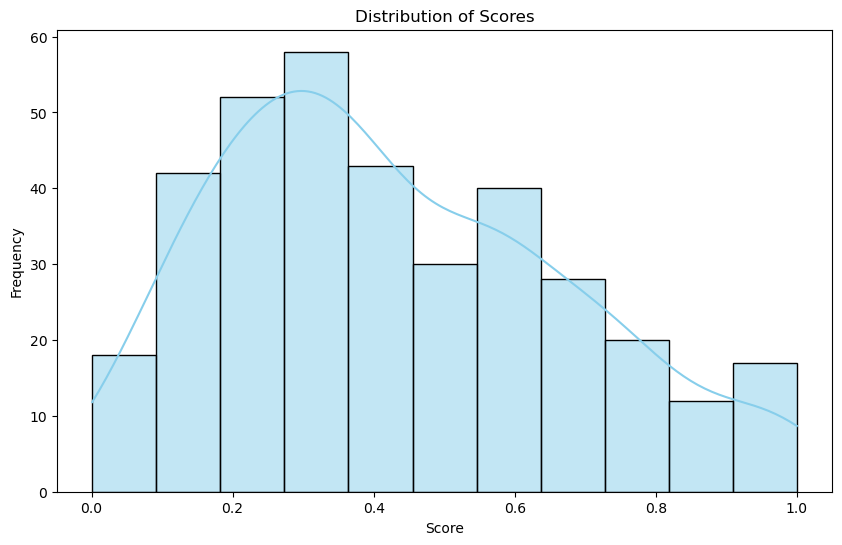

In [291]:
import seaborn as sns

# Query the scores from the well_resourced_score table
cur = conn.cursor()
cur.execute("SELECT score FROM well_resourced_score")
rows = cur.fetchall()

# Fetch the data into a DataFrame
df = pd.DataFrame(rows, columns=['score'])

# Plot the distribution of scores
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], kde=True, color='skyblue')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

In [270]:
import numpy as np

# Connect to the database
conn = psycopg2.connect(database="project", user="postgres", password="12345678", host="localhost", port="5432")

# Query the scores from the well_resourced_score table
cur = conn.cursor()
cur.execute("SELECT score::numeric::float FROM well_resourced_score")
rows = cur.fetchall()

# Fetch the data into a DataFrame
df = pd.DataFrame(rows, columns=['score'])

# Calculate statistics
stats = {
    'Max': df['score'].max(),
    'Min': df['score'].min(),
    'Mean': df['score'].mean(),
    'Median': df['score'].median(),
    'Standard Deviation': df['score'].std(),
    '25th Percentile (Q1)': np.percentile(df['score'], 25),
    '75th Percentile (Q3)': np.percentile(df['score'], 75)
}

# Print statistics
for stat, value in stats.items():
    print(f"{stat}: {value}")


Max: 1.0
Min: 0.0008592722297492549
Mean: 0.4287738947382628
Median: 0.3810067629758833
Standard Deviation: 0.24577016225939974
25th Percentile (Q1): 0.2413866735924119
75th Percentile (Q3): 0.5958060111617889


## Correlation Analysis with Median Income

In [292]:
from scipy.stats import pearsonr

# Query computed scores and median income from SA2 regions
cur = conn.cursor()
cur.execute("""
    SELECT s.score::numeric::float, i.median_income::numeric::float
    FROM well_resourced_score s
    JOIN income i ON s.sa2_code::bigint = i.sa2_code
""")
rows = cur.fetchall()

# Create a DataFrame from the query results
df = pd.DataFrame(rows, columns=['score', 'median_income'])

# Calculate Pearson correlation coefficient and p-value
pearson_corr, p_value = pearsonr(df['score'], df['median_income'])

# Summary
print("Statistical Test for Correlation between Computed Scores and Median Income:")
print("")

# Results
print("Results:")
print(f"Pearson correlation coefficient (r): {pearson_corr:.2f}")
print(f"P-value: {p_value:.3f}")
print("")

# Interpretation
print("Interpretation:")
if pearson_corr > 0:
    print("The positive correlation coefficient suggests that higher computed scores are associated with higher median income.")
else:
    print("The negative correlation coefficient suggests that higher computed scores are associated with lower median income.")
    
if p_value < 0.05:
    print("The correlation is statistically significant.")
else:
    print("The correlation is not statistically significant.")

Statistical Test for Correlation between Computed Scores and Median Income:

Results:
Pearson correlation coefficient (r): 0.05
P-value: 0.365

Interpretation:
The positive correlation coefficient suggests that higher computed scores are associated with higher median income.
The correlation is not statistically significant.


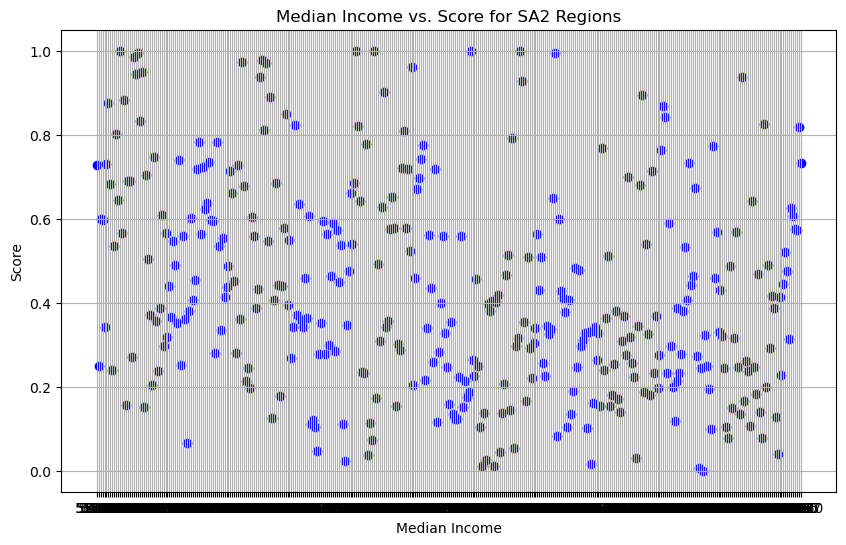

In [295]:
# Fetch median income and scores data from the database
cur.execute("""
    SELECT i.median_income, w.score
    FROM income i
    JOIN well_resourced_score w ON i.sa2_code::bigint = w.sa2_code::bigint
""")
rows = cur.fetchall()

# Extract median income and scores from the fetched data
median_income = [row[0] for row in rows]
scores = [row[1] for row in rows]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_income, scores, color='blue')

# Add labels and title
plt.xlabel('Median Income')
plt.ylabel('Score')
plt.title('Median Income vs. Score for SA2 Regions')

# Show the plot
plt.grid(True)
plt.show()